In [1]:
import sys, os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import weatherbench2 as wb
import metpy
import copy
import wrf
import time
from metpy.units import units
import cartopy.crs as ccrs
print('modules loaded')
import datetime

modules loaded


In [2]:
figpath='/users/mfeldman/figs/'
#EVENT SELECTION ERA5
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5)
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([2020]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([4]))#np.arange(3,10)))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.day.isin([12,13]))
zsurf_c=xr_era5['geopotential_at_surface']

plevel=copy.deepcopy(xr_era5.level.values)
        
xr_era5['pressure'] = (('level'), plevel)
plevel=xr_era5.pressure
xr_dataset = xr_era5.assign_coords(level=np.arange(len(plevel)))
tlevel=xr_era5.temperature
qlevel=xr_era5.specific_humidity
plevel_dim=np.ones([1,len(plevel),1,1])
zlevel=xr_era5.geopotential
ulevel=xr_era5.u_component_of_wind
vlevel=xr_era5.v_component_of_wind
for n1 in range(len(plevel.data)):
    plevel_dim[0,n1,0,0]=plevel[n1]
plevel_exp=(tlevel/tlevel)*plevel_dim
psurf=xr_era5.mean_sea_level_pressure
tsurf=xr_era5['2m_temperature']
zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)

ps_era=psurf/100
zs=zsurf/9.81
zl=zlevel/9.81

In [ ]:
era_cape=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps_era, ter_follow=False)
era_srh=wrf.srhel(u=ulevel, v=vlevel, height=zl, terrain=zs, top=3000.0)

In [3]:
era_cape=era_cape.assign_coords(longitude=psurf.longitude.values);
era_cape=era_cape.assign_coords(latitude=psurf.latitude.values);
era_cape=era_cape.assign_coords(time=psurf.time.values)
cm=plt.cm.Reds
cm.set_under(color="grey")
p = era_cape.sel(mcape_mcin_lcl_lfc='mcape',latitude=slice(50,20),longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=200,vmax=3000,levels=np.arange(200,3000,100),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+'era5_cape.png',  dpi=300, bbox_inches='tight')
plt.close()

era_srh=era_srh.assign_coords(longitude=psurf.longitude.values);
era_srh=era_srh.assign_coords(latitude=psurf.latitude.values);
era_srh=era_srh.assign_coords(time=psurf.time.values)

cm=plt.cm.Reds
cm.set_under(color="grey")
p = era_srh.sel(latitude=slice(50,20),longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=0,vmax=1000,levels=np.arange(0,1000,50),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+'era5_srh.png',  dpi=300, bbox_inches='tight')
plt.close()

In [4]:
era_cape=era_cape.assign_coords(longitude=psurf.longitude.values);
era_cape=era_cape.assign_coords(latitude=psurf.latitude.values); era_cape=era_cape.assign_coords(time=psurf.time.values)
era_srh=era_srh.assign_coords(longitude=psurf.longitude.values);
era_srh=era_srh.assign_coords(latitude=psurf.latitude.values); era_srh=era_srh.assign_coords(time=psurf.time.values)

In [7]:
ifs_init='gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'
xr_model=xr.open_zarr(ifs_init)
xr_init=xr_model.sel(time=xr_model.time.dt.year.isin([2020]))
xr_init=xr_init.sel(time=xr_init.time.dt.month.isin([4]))#np.arange(3,10)))
xr_init=xr_init.sel(time=xr_init.time.dt.day.isin([12,13]))
#xr_init=xr_init.sel(prediction_timedelta=xr_init.prediction_timedelta[0])
print(xr_init.dims)
#xr_init=xr_init.squeeze(dim='prediction_timedelta')

xr_init = xr_init.sortby('level', ascending=False)
plevel=copy.deepcopy(xr_init.level.values)
xr_init['pressure'] = (('level'), plevel)
plevel=xr_init.pressure
xr_init = xr_init.assign_coords(level=np.arange(len(plevel)))

tlevel=xr_init.temperature
qlevel=xr_init.specific_humidity
plevel_dim=np.ones([1,len(plevel),1,1])
zlevel=xr_init.geopotential
ulevel=xr_init.u_component_of_wind
vlevel=xr_init.v_component_of_wind
for n1 in range(len(plevel.data)):
    plevel_dim[0,n1,0,0]=plevel[n1]
plevel_exp=(tlevel/tlevel)*plevel_dim

psurf=xr_init.mean_sea_level_pressure
tsurf=xr_init['2m_temperature']
zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)

ps=psurf/100
zs=zsurf/9.81
zl=zlevel/9.81

init_cape=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps, ter_follow=False)
init_srh=wrf.srhel(u=ulevel, v=vlevel, height=zl, terrain=zs, top=3000.0)

init_cape=init_cape.assign_coords(longitude=psurf.longitude.values);
init_cape=init_cape.assign_coords(latitude=psurf.latitude.values);
init_cape=init_cape.assign_coords(time=psurf.time.values)
init_srh=init_srh.assign_coords(longitude=psurf.longitude.values);
init_srh=init_srh.assign_coords(latitude=psurf.latitude.values);
init_srh=init_srh.assign_coords(time=psurf.time.values)

Frozen({'time': 8, 'latitude': 721, 'longitude': 1440, 'level': 13})


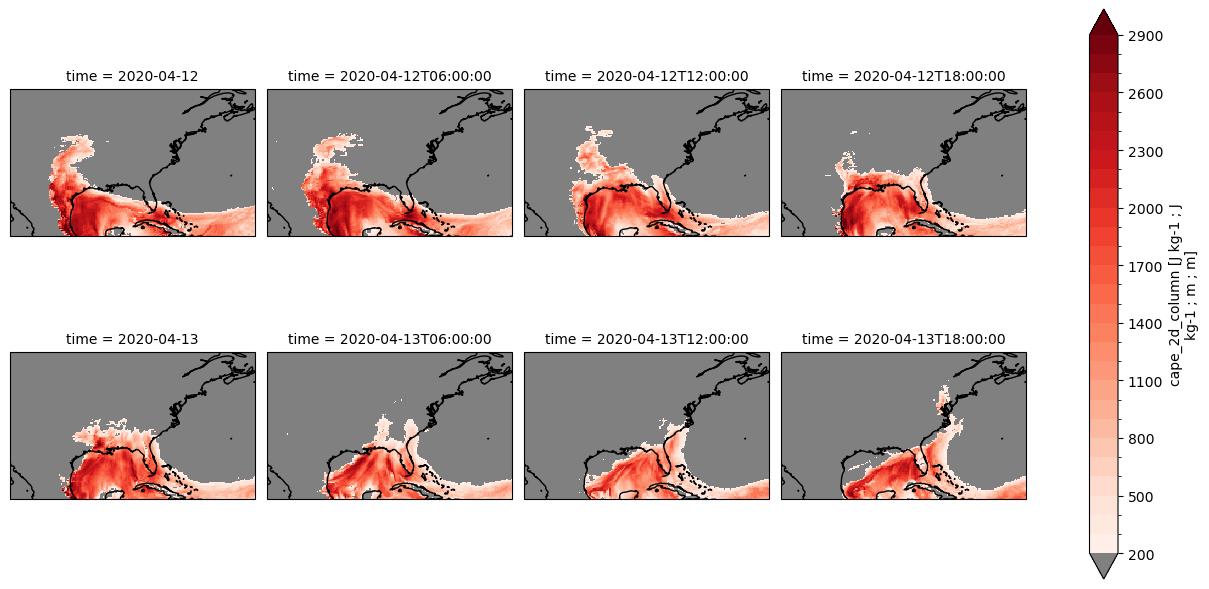

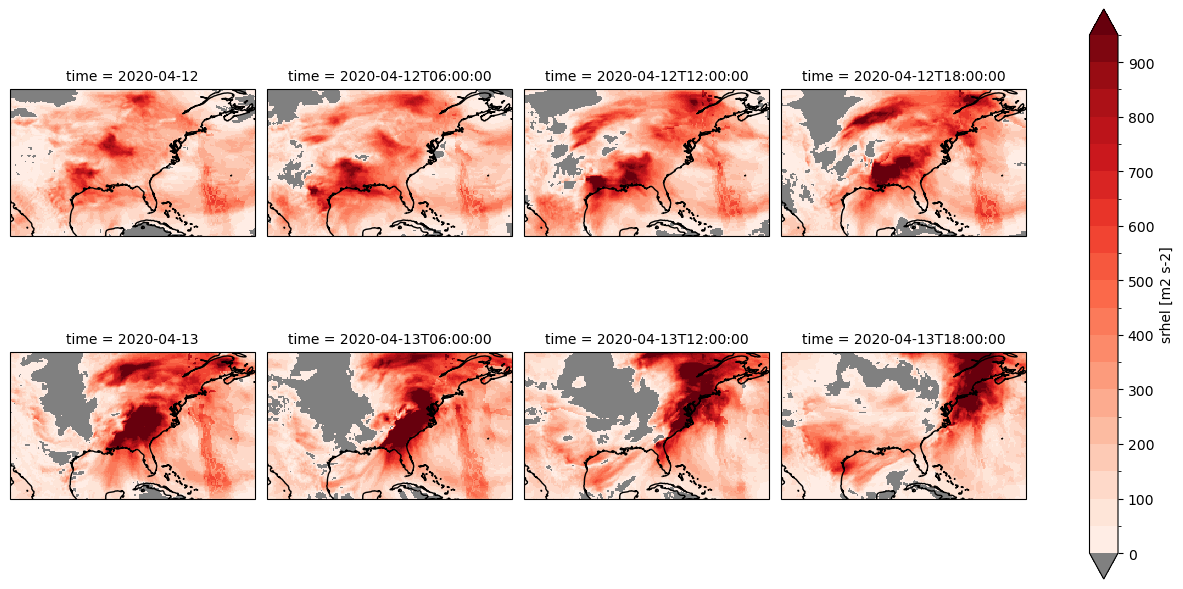

In [11]:
cm=plt.cm.Reds
cm.set_bad(color="grey")
cm.set_under(color="grey")
p = init_cape.sel(mcape_mcin_lcl_lfc='mcape',latitude=slice(20,50),longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=200,vmax=3000,levels=np.arange(200,3000,100),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+'ifsinit_cape.png',  dpi=300, bbox_inches='tight')
#plt.close()

cm=plt.cm.Reds
cm.set_under(color="grey")
p = init_srh.sel(latitude=slice(20,50),longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=0,vmax=1000,levels=np.arange(0,1000,50),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+'ifsinit_srh.png',  dpi=300, bbox_inches='tight')
#plt.close()

In [16]:
print(init_cape.shape,init_cape.dims)
print(init_cape.time)

(4, 4, 721, 1440) ('mcape_mcin_lcl_lfc', 'time', 'latitude', 'longitude')
<xarray.DataArray 'time' (time: 4)>
array(['2020-04-12T00:00:00.000000000', '2020-04-12T12:00:00.000000000',
       '2020-04-13T00:00:00.000000000', '2020-04-13T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-04-12 ... 2020-04-13T12:00:00


In [9]:
start=xr_era5.time[0]
end=xr_era5.time[-1]

ref_cape=init_cape; ref_srh=init_srh
#LOADING FORECAST DATASET
model='pangu'
model='ifs'
latslice=slice(50,20)
latslice=slice(20,50)
dataset='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
dataset='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
days=[6,7,8,9,10,11,12]
hours=[0,12]
for day in days[:]:
    for hour in hours[:]:
        xr_model=xr.open_zarr(dataset)
        xr_dataset=xr_model.sel(time=xr_model.time.dt.year.isin([2020]))
        xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.month.isin([4]))
        xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.day.isin([day]))
        xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.hour.isin([hour]))
        fcst_init=xr_dataset.time[0]
        init=fcst_init.dt.strftime('%Y%m%d%H').values; print(init)
        xr_dataset=xr_dataset.sel(prediction_timedelta=slice(start-fcst_init,end-fcst_init))
        xr_dataset = xr_dataset.sortby('level', ascending=False)
        
        plevel=copy.deepcopy(xr_dataset.level.values)
        
        xr_dataset['pressure'] = (('level'), plevel)
        plevel=xr_dataset.pressure
        xr_dataset = xr_dataset.assign_coords(level=np.arange(len(plevel)))
        
        tlevel=xr_dataset.temperature
        qlevel=xr_dataset.specific_humidity
        plevel_dim=np.ones([1,len(plevel),1,1])
        zlevel=xr_dataset.geopotential
        ulevel=xr_dataset.u_component_of_wind
        vlevel=xr_dataset.v_component_of_wind
        for n1 in range(len(plevel.data)):
            plevel_dim[0,n1,0,0]=plevel[n1]
        plevel_exp=(tlevel/tlevel)*plevel_dim
        
        psurf=xr_dataset.mean_sea_level_pressure
        tsurf=xr_dataset['2m_temperature']
        zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0)
        zsurf = zsurf.expand_dims(dim={"prediction_timedelta": psurf.prediction_timedelta}, axis=1)
        
        ps=psurf/100
        zs=zsurf/9.81
        zl=zlevel/9.81

        cape=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps, ter_follow=False)
        srh=wrf.srhel(u=ulevel, v=vlevel, height=zl, terrain=zs, top=3000.0)

        cape=cape.assign_coords(longitude=psurf.longitude.values);
        cape=cape.assign_coords(latitude=psurf.latitude.values);
        cape=cape.assign_coords(prediction_timedelta=ps_era.time.values)

        srh=srh.assign_coords(longitude=psurf.longitude.values);
        srh=srh.assign_coords(latitude=psurf.latitude.values);
        srh=srh.assign_coords(prediction_timedelta=ps_era.time.values)

        cape=cape.squeeze(dim='time'); cape=cape.rename({'prediction_timedelta':'time'})
        srh=srh.squeeze(dim='time'); srh=srh.rename({'prediction_timedelta':'time'})
        
        cm=plt.cm.Reds
        cm.set_bad(color="grey")
        cm.set_under(color="grey")
        p = cape.sel(mcape_mcin_lcl_lfc='mcape',latitude=latslice,longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time",\
                         col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},\
                         cmap=cm,vmin=200,vmax=3000,levels=np.arange(200,3000,100),extend='both')# col_wrap=4)
        for ax in p.axs.flat:
                        ax.coastlines()
        f=p.fig
        f.savefig(figpath+model+init+'_cape.png',  dpi=300, bbox_inches='tight')
        plt.close()

        
        cm=plt.cm.Reds
        cm.set_bad(color="grey")
        cm.set_under(color="grey")
        p = srh.sel(latitude=latslice,longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time",\
                         col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},\
                         cmap=cm,vmin=0,vmax=1000,levels=np.arange(0,1000,50),extend='both')# col_wrap=4)
        for ax in p.axs.flat:
                        ax.coastlines()
        f=p.fig
        f.savefig(figpath+model+init+'_srh.png',  dpi=300, bbox_inches='tight')
        plt.close()



        #cape=cape.sel(time=cape.time.dt.hour.isin([0,12]))
        #srh=srh.sel(time=srh.time.dt.hour.isin([0,12]))
        cm=plt.cm.RdBu_r
        cm.set_bad(color="grey")
        dcape=cape.fillna(0)-ref_cape.fillna(0)
        dsrh=srh.fillna(0)-ref_srh.fillna(0)
        p = dcape.sel(mcape_mcin_lcl_lfc='mcape',latitude=latslice,longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time",\
                         col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},\
                         cmap=cm,vmin=-1000,vmax=1000,levels=np.arange(-1000,1010,100),extend='both')# col_wrap=4)
        for ax in p.axs.flat:
                        ax.coastlines()
        f=p.fig
        f.savefig(figpath+model+init+'_cape_d.png',  dpi=300, bbox_inches='tight')
        plt.close()


        cm=plt.cm.RdBu_r
        cm.set_bad(color="grey")
        p = dsrh.sel(latitude=latslice,longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time",\
                         col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},\
                         cmap=cm,vmin=-500,vmax=500,levels=np.arange(-500,505,50),extend='both')# col_wrap=4)
        for ax in p.axs.flat:
                        ax.coastlines()
        f=p.fig
        f.savefig(figpath+model+init+'_srh_d.png',  dpi=300, bbox_inches='tight')
        plt.close()

2020040600
2020040612
2020040700
2020040712
2020040800
2020040812
2020040900
2020040912
2020041000
2020041012
2020041100
2020041112
2020041200
2020041212


ValueError: conflicting sizes for dimension 'prediction_timedelta': length 6 on <this-array> and length 8 on {'mcape_mcin_lcl_lfc': 'mcape_mcin_lcl_lfc', 'longitude': 'longitude', 'latitude': 'latitude', 'prediction_timedelta': 'prediction_timedelta', 'time': <this-array>}

In [10]:
print(xr_model.prediction_timedelta)

<xarray.DataArray 'prediction_timedelta' (prediction_timedelta: 41)>
array([              0,  21600000000000,  43200000000000,  64800000000000,
        86400000000000, 108000000000000, 129600000000000, 151200000000000,
       172800000000000, 194400000000000, 216000000000000, 237600000000000,
       259200000000000, 280800000000000, 302400000000000, 324000000000000,
       345600000000000, 367200000000000, 388800000000000, 410400000000000,
       432000000000000, 453600000000000, 475200000000000, 496800000000000,
       518400000000000, 540000000000000, 561600000000000, 583200000000000,
       604800000000000, 626400000000000, 648000000000000, 669600000000000,
       691200000000000, 712800000000000, 734400000000000, 756000000000000,
       777600000000000, 799200000000000, 820800000000000, 842400000000000,
       864000000000000], dtype='timedelta64[ns]')
Coordinates:
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
Attributes:
    long_name:      time 

In [10]:
start=xr_era5.time[0]
end=xr_era5.time[-1]
mlpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/'
import glob
#ref_cape=init_cape; ref_srh=init_srh
#LOADING FORECAST DATASET
model='pangu_dawn'
latslice=slice(50,20)
latslice=slice(20,50)
year=2020; month=4
days=[6,7,8,9,10,11,12]
hours=[0,12]
for day in days[:1]:
    for hour in hours[:1]:
        filelist=sorted(glob.glob(mlpath+'*'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'*'))
        #print(filelist)
        st=datetime.datetime(start.dt.year.values,start.dt.month.values,start.dt.day.values,start.dt.hour.values)
        et=datetime.datetime(end.dt.year.values,end.dt.month.values,end.dt.day.values,end.dt.hour.values)
        dat=datetime.datetime(year, month, day, hour)
        lt1=int((st-dat).total_seconds() / 3600)#,tzinfo=datetime.timezone.utc)
        lt2=int((et-dat).total_seconds() / 3600)
        lt=np.arange(lt1,lt2+1,6).astype(str)
        print(lt)
        filtered_files = [file for file in filelist if any(part in file for part in lt)]
        print(filtered_files)
        xr_dataset=xr.open_mfdataset(filtered_files,concat_dim='prediction_timedelta',combine='nested',engine='cfgrib')
        xr_tdata=xr.open_mfdataset(filtered_files,concat_dim='prediction_timedelta',combine='nested',engine='cfgrib', backend_kwargs={'filter_by_keys': {'shortName': '2t'}})

        #xr_model=xr.open_zarr(dataset)

Can't create file '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_144h.grib.923a8.idx'
Traceback (most recent call last):
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10/site-packages/cfgrib/messages.py", line 534, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10/contextlib.py", line 135, in __enter__
    return next(self.gen)
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10/site-packages/cfgrib/messages.py", line 500, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_144h.grib.923a8.idx'
Can't read index file '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_144h.grib.92

['144' '150' '156' '162' '168' '174' '180' '186']
['/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_144h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_150h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_156h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_162h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_168h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_1200_144h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_1200_150h.grib', '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_1200_1

skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=10.0) new_value=Variable(dimensions=(), data=2.0)
Can't create file '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ML_PREDICT/panguweather/Data_Monika/pangu_d_20200406_t_0000_150h.grib.923a8.idx'
Traceback (most recent call last):
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10/site-packages/cfgrib/messages.py", line 534, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/users/mfeldman/.conda/envs/wb/lib/python3.10

In [14]:
print(xr_tdata['2t'])

KeyError: '2t'